In [24]:
Verbose = False
if Verbose:
    def vprint(*args, **kwargs): print(*args, **kwargs, flush=True)
else: # do-nothing function
    def vprint(*args, **kwargs): None

In [25]:
import torch
import numpy as np
import pandas as pd
pd.set_option("display.width", 380)
pd.set_option('max_colwidth', 100)

import matplotlib.pyplot as plt

from IPython.display import display

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Load the sentences

In [26]:
df_train = pd.read_csv("./sick_train/SICK_train.txt", sep="\t")
df_train = df_train.drop(['relatedness_score'], axis=1)

df_dev = pd.read_csv("./sick_trial/SICK_trial.txt", sep="\t")
df_dev = df_dev.drop(['relatedness_score'], axis=1)

df_test = pd.read_csv("./sick_test/SICK_test.txt", sep="\t")
df_test = df_test.drop(['relatedness_score'], axis=1)

In [27]:
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

In [28]:
from gensim import corpora

In [29]:
class SickDataset(Dataset):
    endOfSentence   = '</s>'
    startOfSentence = '<s>'
    separator2Sentences = '<sep>'
    
    text_label = ["NEUTRAL", "ENTAILMENT", "CONTRADICTION"]
    
    tokens = [startOfSentence, separator2Sentences, endOfSentence]
    
    def join_sentence(self, row):
        """
        Create a new sentence (<s> + s_A + <sep> + s_B + </s>)
        """
        sentence_a = row['sentence_A'].lower().split(" ")
        sentence_b = row['sentence_B'].lower().split(" ")
        return np.concatenate((
            [self.startOfSentence],
            sentence_a,
            [self.separator2Sentences],
            sentence_b,
            [self.endOfSentence]
        ))
    
    def series_text_2_labelID(self, series, keep_n=1000):
        """
        Convert text Label into label id
        """
        reverse_dict = {v: k for k, v in  dict(enumerate(self.text_label)).items()}
        return series.map(reverse_dict)
    
    def series_2_dict(self, series, keep_n):
        """
        Convert document (a list of words) into a list of indexes
        AND apply some filter on the documents
        """
        dictionary = corpora.Dictionary(series)
        dictionary.filter_extremes(
            no_below=1,
            no_above=1,
            keep_n=keep_n,
            keep_tokens=self.tokens)
        return dictionary
    
    
    def __init__(self, df, vocabulary_size, dic=None):
        # Label text as ids
        df["entailment_id"] = self.series_text_2_labelID(df['entailment_judgment'])
        
        # Add <s>,</s>,<sep> tokens to the vocabulary
        df['sentence_AB'] = df.apply(self.join_sentence, axis=1)
        
        # check if the dictionary is given
        if dic is None:
            # Create the Dictionary
            self.dictionary = self.series_2_dict(df['sentence_AB'], vocabulary_size)
        else:
            self.dictionary = dic
        
        # sentence of words -> array of idx
        # Adds unknown to the voc (idx = len(dictionary)), len(dictionary) = vocabulary_size
        # Adds one to each (no tokens at 0, even <unk>)
        # 0 is for the padding when using mini-batch
        df["word_idx"] = df["sentence_AB"].apply(
            lambda word: np.array(self.dictionary.doc2idx(word, unknown_word_index=vocabulary_size)) + 1
        )
        
        self.df = df
        
    def getRef(self, index):
        return self.df['sentence_AB'][index]
        
    def __getitem__(self, index):
        return (
            self.df['word_idx'][index],
            self.df['entailment_id'][index])
    
    def getDictionary(self):
        return self.dictionary
    
    def __len__(self):
        return len(self.df)

    
vocabulary_size = 1500

# Dataset

In [53]:
# Create the train dataset
sick_dataset_train = SickDataset(df_train, vocabulary_size)
sick_dataset_train.df.head()

,pair_ID,sentence_A,sentence_B,entailment_judgment,entailment_id,sentence_AB,word_idx
0,1,A group of kids is playing in a yard and an old man is standing in the background,A group of boys in a yard is playing and a man is standing in the background,NEUTRAL,0,"[<s>, a, group, of, kids, is, playing, in, a, yard, and, an, old, man, is, standing, in, the, ba...","[2, 4, 9, 14, 12, 11, 16, 10, 4, 19, 6, 5, 15, 13, 11, 17, 10, 18, 7, 3, 4, 9, 14, 8, 10, 4, 19,..."
1,2,A group of children is playing in the house and there is no man standing in the background,A group of kids is playing in a yard and an old man is standing in the background,NEUTRAL,0,"[<s>, a, group, of, children, is, playing, in, the, house, and, there, is, no, man, standing, in...","[2, 4, 9, 14, 20, 11, 16, 10, 18, 21, 6, 23, 11, 22, 13, 17, 10, 18, 7, 3, 4, 9, 14, 12, 11, 16,..."
2,3,The young boys are playing outdoors and the man is smiling nearby,The kids are playing outdoors near a man with a smile,ENTAILMENT,1,"[<s>, the, young, boys, are, playing, outdoors, and, the, man, is, smiling, nearby, <sep>, the, ...","[2, 18, 31, 8, 24, 16, 27, 6, 18, 13, 11, 29, 26, 3, 18, 12, 24, 16, 27, 25, 4, 13, 30, 4, 28, 1]"
3,5,The kids are playing outdoors near a man with a smile,A group of kids is playing in a yard and an old man is standing in the background,NEUTRAL,0,"[<s>, the, kids, are, playing, outdoors, near, a, man, with, a, smile, <sep>, a, group, of, kids...","[2, 18, 12, 24, 16, 27, 25, 4, 13, 30, 4, 28, 3, 4, 9, 14, 12, 11, 16, 10, 4, 19, 6, 5, 15, 13, ..."
4,9,The young boys are playing outdoors and the man is smiling nearby,A group of kids is playing in a yard and an old man is standing in the background,NEUTRAL,0,"[<s>, the, young, boys, are, playing, outdoors, and, the, man, is, smiling, nearby, <sep>, a, gr...","[2, 18, 31, 8, 24, 16, 27, 6, 18, 13, 11, 29, 26, 3, 4, 9, 14, 12, 11, 16, 10, 4, 19, 6, 5, 15, ..."


In [31]:
# Create the dev dataset
dictionary_train = sick_dataset_train.getDictionary()

sick_dataset_dev = SickDataset(df_dev, vocabulary_size, dictionary_train)

In [32]:
# Create the test dataset
sick_dataset_test = SickDataset(df_test, vocabulary_size, dictionary_train)

In [51]:
pd.DataFrame(list(zip(sick_dataset_train.getRef(6)[-10:], sick_dataset_train[2][0]))).T

,0,1,2,3,4,5,6,7,8,9
0,the,man,in,pants,<sep>,two,dogs,are,fighting,</s>
1,2,18,31,8,24,16,27,6,18,13


# Pretrained embeddings
https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76  
For each word in dataset’s vocabulary, we check if it is on GloVe’s vocabulary. If it do it, we load its pre-trained word vector. Otherwise, we initialize a random vector.

In [34]:
EMBEDDINGS_SIZE = 50

In [35]:
from torchtext import vocab
#vocab is shared across all the text fields
#CAUTION: GloVe will download all embeddings locally (862 MB).
pretrained_emb = vocab.GloVe(name='6B', dim=EMBEDDINGS_SIZE)

# 0 is for the padding when using mini-batch (start at one, shift by one)
weights_matrix = np.zeros((vocabulary_size + 2, EMBEDDINGS_SIZE)) # do not forget the unk

found = 0
no_found = 0
# build a matrix of weights that will be loaded into the PyTorch embedding layer
for word_id in sick_dataset_train.dictionary:
    word = sick_dataset_train.dictionary[word_id]
    if word in pretrained_emb.stoi:
        pretrained_emb_ID = pretrained_emb.stoi[word]
        
        weights_matrix[word_id+1] = pretrained_emb.vectors[pretrained_emb_ID]
        found += 1
    else:
        weights_matrix[word_id+1] = np.random.normal(scale=0.6, size=(EMBEDDINGS_SIZE, ))
        no_found += 1
        
# UNK
weights_matrix[vocabulary_size+1] = np.random.normal(scale=0.6, size=(EMBEDDINGS_SIZE, ))

print(found, no_found)
        
pretrained_emb_vec = torch.tensor(weights_matrix, dtype=torch.float32)
print("Downloaded: Pretained Embedding matrix: " +  str(pretrained_emb.vectors.size()))
print("Adapted:    Pretained Embedding matrix: " +  str(pretrained_emb_vec.size()))

1444 56
Downloaded: Pretained Embedding matrix: torch.Size([400000, 50])
Adapted:    Pretained Embedding matrix: torch.Size([1502, 50])


In [36]:
print(sick_dataset_train.dictionary.doc2idx(["the", "The"]))
print(sick_dataset_train.dictionary[17])
print(pretrained_emb_vec[17+1])
# Glove dim=50 word=the vector[:4] = 0.418 0.24968 -0.41242 0.1217

[17, -1]
the
tensor([ 0.4180,  0.2497, -0.4124,  0.1217,  0.3453, -0.0445, -0.4969, -0.1786,
        -0.0007, -0.6566,  0.2784, -0.1477, -0.5568,  0.1466, -0.0095,  0.0117,
         0.1020, -0.1279, -0.8443, -0.1218, -0.0168, -0.3328, -0.1552, -0.2313,
        -0.1918, -1.8823, -0.7675,  0.0991, -0.4212, -0.1953,  4.0071, -0.1859,
        -0.5229, -0.3168,  0.0006,  0.0074,  0.1778, -0.1590,  0.0120, -0.0542,
        -0.2987, -0.1575, -0.3476, -0.0456, -0.4425,  0.1878,  0.0028, -0.1841,
        -0.1151, -0.7858])


# To DataLoader

In [14]:
from torch.utils.data import DataLoader

In [15]:
def pad_collate(batch):
    seqs_labels = np.array(batch)[:,1]
    
    vectorized_seqs = np.array(batch)[:,0]
    seq_lengths = torch.LongTensor([len(x) for x in vectorized_seqs])
    
    seq_tensor = torch.zeros((len(vectorized_seqs), seq_lengths.max())).long()
    for idx, (seq, seq_len) in enumerate(zip(vectorized_seqs, seq_lengths)):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)
        
    vectorized_seqs = np.array(seq_tensor)
    
    return torch.tensor(vectorized_seqs), torch.LongTensor([ x for x in seqs_labels])


BATCH_SIZE = 8

train_loader = DataLoader(dataset=sick_dataset_train,
                          batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)

dev_loader = DataLoader(dataset=sick_dataset_dev,
                          batch_size=1, shuffle=False)

test_loader = DataLoader(dataset=sick_dataset_test,
                          batch_size=1, shuffle=False)

# Debug the padding
# display([ x for x in enumerate(train_loader)][0]) # has padding (sample of same size padded with 0)
# display([ x for x in enumerate(dev_loader)][0]) # no batch == no padding

# Evaluation helpers

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_recall_fscore_support

import itertools
import io
from tensorboardX.utils import figure_to_image
import matplotlib

def confusion_scores(total_labels, total_pred, writer=None):
    fig = plt.figure(figsize=(10,10))
    classes = SickDataset.text_label
    title='Confusion matrix'
    
    cm = confusion_matrix(total_labels, total_pred, labels=[0, 1, 2])
    
    plt.rcParams["figure.figsize"] = [10, 10]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, color='gray', fontsize=24)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, [c.lower() for c in classes], rotation=45 , style='italic', color='gray', fontsize=17)
    plt.yticks(tick_marks, [c.lower() for c in classes], color='gray', style='italic', fontsize=17)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', color='gray', fontsize=19)
    plt.xlabel('Predicted label', color='gray', fontsize=19)
    plt.tight_layout()
    plt.show()
    if writer != None:
        writer.add_figure('plt/confusion_matrix', fig, 0)


def evaluate(model, loader, whileTraining=False, criterion=None, writer=None):
    """
    Displays the confusion_matrix the precision recall fscore
    If in whileTrainnig Mode only return the accuracy and loss
    """
    model.eval()
    with torch.no_grad():
        total_labels = []
        total_pred = []
        train_loss_batches = 0
        train_loss_batches_count = 0
        for batch_idx, (data, target) in enumerate(loader):

                data = data.to(device)
                target = target.to(device)

                output = rnn(data)
                
                if whileTraining and criterion != None:
                    loss = criterion(output, target)
                    train_loss_batches +=loss.cpu().detach().numpy()
                    train_loss_batches_count += 1

                # Get the Accuracy
                _, predicted = torch.max(output.data, dim=1)
                correct = (predicted == target).sum().item()
                
                total_labels.append(list(target.cpu().numpy()))
                total_pred.append(list(predicted.cpu().numpy()))
                
        model.train()
        if whileTraining and criterion!=None:
            return ((accuracy_score(total_labels, total_pred) * 100), train_loss_batches / train_loss_batches_count)

                
        confusion_scores(total_labels, total_pred, writer=writer)
        
        print("Accuracy:  {:.4f}".format(accuracy_score(total_labels, total_pred)))
        
        # compute per-label precisions, recalls, F1-scores, and supports instead of averaging 
        metrics = precision_recall_fscore_support(
                                        total_labels, total_pred,
                                        average=None, labels=[0, 1, 2])
        
        df = pd.DataFrame(list(metrics), index=['Precision', 'Recall', 'Fscore', 'support'],
                                   columns=SickDataset.text_label)
        df = df.drop(['support'], axis=0)
        display(df.T)
        


# Create the RNN Model

In [17]:
from torch import nn

In [18]:
class RNNClassifier(nn.Module):
    # Our model

    def __init__(self, input_voc_size, embedding_size, hidden_size):
        super(RNNClassifier, self).__init__()
        
        self.input_voc_size = input_voc_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.rnn_out_size = hidden_size * 2

        
        self.num_classes = 3
        
        # Add the padding token (0) (+1 to voc_size)
        # Pads the output with the embedding vector at padding_idx whenever it encounters the index..
        self.embedding = nn.Embedding(input_voc_size+1, embedding_size, padding_idx=0)
        # Load the pretrained embeddings
        # self.embedding.weight = nn.Parameter(pretrained_emb_vec) 
        # embeddings fine-tuning
        self.embedding.weight.requires_grad = False
        
        self.rnn = nn.GRU(
              input_size=embedding_size,
              hidden_size=hidden_size,
              batch_first=True,
              bidirectional=True,
        )
        
        self.fc1 = nn.Linear(self.rnn_out_size, self.num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    # input shape: B x S (input size)
    def forward(self, x):
        
        vprint("\nsize input", x.size())
        batch_size = x.size(0)
        
        # Initialize hidden (num_layers * num_directions, batch_size, hidden_size)
        h_0 = torch.zeros(2, batch_size, self.hidden_size)
        vprint("size hidden init", h_0.size())
        
        # When creating new variables inside a model (like the hidden state in an RNN/GRU/LSTM),
        # make sure to also move them to the device (GPU or CPU).
        h_0 = h_0.to(device)

        # Embedding B x S -> B x S x I (embedding size)
        emb = self.embedding(x)
        vprint("size Embedding", emb.size())
        
        # Propagate embedding through RNN
        # Input: (batch, seq_len, embedding_size)
        # h_0: (num_layers * num_directions, batch, hidden_size)
        out, hidden = self.rnn(emb, h_0)
        
        vprint("size hidden", hidden.size())
        
        rnn_out = torch.cat((hidden[0], hidden[1]), 1)
        vprint("size rnn out", rnn_out.size())
        
        
        # Use the last layer output as FC's input
        layout_fc1 = self.fc1(rnn_out)
        vprint("size layout fc1", layout_fc1.size())
        
        fc_output = self.softmax(layout_fc1)
        
        return fc_output    
    
# Add the unknown token (+1 to voc_size)
rnn = RNNClassifier(vocabulary_size+1, EMBEDDINGS_SIZE, 20)
rnn.to(device)
print(rnn)

# Set loss and optimizer function
# CrossEntropyLoss = LogSoftmax + NLLLoss
weights = [1-((sick_dataset_train.df['entailment_id'] == i).sum() / len(sick_dataset_train)) for i in range(3)]
class_weights = torch.FloatTensor(weights).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.002)

RNNClassifier(
  (embedding): Embedding(1502, 50, padding_idx=0)
  (rnn): GRU(50, 20, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=40, out_features=3, bias=True)
  (softmax): Softmax()
)


In [ ]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()

# Training the Model 

In [ ]:
%%time
# Train the model

num_epochs=400

iter = 0

rnn.train()
for epoch in range(num_epochs):
    total_correct = 0
    total_target = 0
    train_loss_batches = 0
    train_loss_batches_count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device)
        target = target.to(device)
        
        output = rnn(data)
        
        vprint(output)
        loss = criterion(output, target)
        
        
        train_loss_batches += loss.cpu().detach().numpy()
        train_loss_batches_count += 1
        
        rnn.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Get the Accuracy
        _, predicted = torch.max(output.data, dim=1)
        correct = (predicted == target).sum().item()
        
        total_correct += correct
        total_target += target.size(0)
        
        if batch_idx % 200 == 0 or batch_idx % 200 == 1 or batch_idx == len(train_loader)-1:
            print('\rEpoch [{:3}/{}] | Step [{:5}/{} ({:3.0f}%)] | Loss {:.3f} | Accuracy {:.2f}%'.format(
                    epoch+1, num_epochs,
                    batch_idx * len(data), 
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), 
                    loss.item(), 
                    (total_correct / total_target) * 100), end=' ')
            
            accuracy_dev, loss_dev = evaluate(rnn, dev_loader, criterion=criterion, whileTraining=True)
            print("@ Loss_dev {:.3f} | Accuracy_dev {:.2f}%".format(loss_dev, accuracy_dev))
            
            writer.add_scalars('data/loss', {'train': train_loss_batches / train_loss_batches_count,
                                             'dev': loss_dev}, iter)
            iter += 1
            
        if Verbose:
            break
            


print("Learning finished!")

Epoch [  1/400] | Step [    0/4500 (  0%)] | Loss 1.105 | Accuracy 37.50% @ Loss_dev 1.087 | Accuracy_dev 32.00%
Epoch [  1/400] | Step [    8/4500 (  0%)] | Loss 1.092 | Accuracy 43.75% @ Loss_dev 1.097 | Accuracy_dev 28.60%
Epoch [  1/400] | Step [ 1600/4500 ( 36%)] | Loss 1.097 | Accuracy 53.30% @ Loss_dev 0.962 | Accuracy_dev 59.00%
Epoch [  1/400] | Step [ 1608/4500 ( 36%)] | Loss 1.117 | Accuracy 53.22% @ Loss_dev 0.962 | Accuracy_dev 59.00%
Epoch [  1/400] | Step [ 3200/4500 ( 71%)] | Loss 1.041 | Accuracy 54.68% @ Loss_dev 0.954 | Accuracy_dev 59.00%
Epoch [  1/400] | Step [ 3208/4500 ( 71%)] | Loss 0.781 | Accuracy 54.73% @ Loss_dev 0.954 | Accuracy_dev 59.00%
Epoch [  1/400] | Step [ 2248/4500 (100%)] | Loss 0.905 | Accuracy 54.84% @ Loss_dev 0.973 | Accuracy_dev 55.80%
Epoch [  2/400] | Step [    0/4500 (  0%)] | Loss 1.075 | Accuracy 37.50% @ Loss_dev 0.972 | Accuracy_dev 56.20%
Epoch [  2/400] | Step [    8/4500 (  0%)] | Loss 0.817 | Accuracy 62.50% @ Loss_dev 0.970 | Acc

Epoch [ 21/400] | Step [ 3200/4500 ( 71%)] | Loss 0.553 | Accuracy 80.30% @ Loss_dev 0.976 | Accuracy_dev 56.40%
Epoch [ 21/400] | Step [ 3208/4500 ( 71%)] | Loss 0.692 | Accuracy 80.32% @ Loss_dev 0.976 | Accuracy_dev 56.40%
Epoch [ 21/400] | Step [ 2248/4500 (100%)] | Loss 0.553 | Accuracy 79.80% @ Loss_dev 0.954 | Accuracy_dev 59.60%
Epoch [ 22/400] | Step [    0/4500 (  0%)] | Loss 0.929 | Accuracy 62.50% @ Loss_dev 0.953 | Accuracy_dev 59.60%
Epoch [ 22/400] | Step [    8/4500 (  0%)] | Loss 0.640 | Accuracy 75.00% @ Loss_dev 0.952 | Accuracy_dev 59.60%
Epoch [ 22/400] | Step [ 1600/4500 ( 36%)] | Loss 0.975 | Accuracy 80.04% @ Loss_dev 0.968 | Accuracy_dev 57.80%
Epoch [ 22/400] | Step [ 1608/4500 ( 36%)] | Loss 0.725 | Accuracy 80.07% @ Loss_dev 0.967 | Accuracy_dev 57.80%
Epoch [ 22/400] | Step [ 3200/4500 ( 71%)] | Loss 0.653 | Accuracy 80.42% @ Loss_dev 0.945 | Accuracy_dev 60.80%
Epoch [ 22/400] | Step [ 3208/4500 ( 71%)] | Loss 0.712 | Accuracy 80.44% @ Loss_dev 0.945 | Acc

Epoch [ 42/400] | Step [    8/4500 (  0%)] | Loss 0.709 | Accuracy 93.75% @ Loss_dev 0.965 | Accuracy_dev 58.00%
Epoch [ 42/400] | Step [ 1600/4500 ( 36%)] | Loss 0.794 | Accuracy 85.45% @ Loss_dev 0.943 | Accuracy_dev 61.00%
Epoch [ 42/400] | Step [ 1608/4500 ( 36%)] | Loss 0.653 | Accuracy 85.46% @ Loss_dev 0.944 | Accuracy_dev 60.60%
Epoch [ 42/400] | Step [ 3200/4500 ( 71%)] | Loss 0.627 | Accuracy 83.29% @ Loss_dev 0.934 | Accuracy_dev 61.60%
Epoch [ 42/400] | Step [ 3208/4500 ( 71%)] | Loss 0.552 | Accuracy 83.33% @ Loss_dev 0.934 | Accuracy_dev 61.60%
Epoch [ 42/400] | Step [ 2248/4500 (100%)] | Loss 1.077 | Accuracy 83.18% @ Loss_dev 0.950 | Accuracy_dev 59.80%
Epoch [ 43/400] | Step [    0/4500 (  0%)] | Loss 0.564 | Accuracy 100.00% @ Loss_dev 0.950 | Accuracy_dev 59.40%
Epoch [ 43/400] | Step [    8/4500 (  0%)] | Loss 0.751 | Accuracy 93.75% @ Loss_dev 0.950 | Accuracy_dev 59.40%
Epoch [ 43/400] | Step [ 1600/4500 ( 36%)] | Loss 1.075 | Accuracy 83.77% @ Loss_dev 0.945 | Ac

Epoch [ 62/400] | Step [ 3208/4500 ( 71%)] | Loss 0.747 | Accuracy 85.54% @ Loss_dev 0.948 | Accuracy_dev 58.40%
Epoch [ 62/400] | Step [ 2248/4500 (100%)] | Loss 0.742 | Accuracy 85.89% @ Loss_dev 0.929 | Accuracy_dev 61.40%
Epoch [ 63/400] | Step [    0/4500 (  0%)] | Loss 0.553 | Accuracy 100.00% @ Loss_dev 0.929 | Accuracy_dev 61.40%
Epoch [ 63/400] | Step [    8/4500 (  0%)] | Loss 0.552 | Accuracy 100.00% @ Loss_dev 0.929 | Accuracy_dev 61.40%
Epoch [ 63/400] | Step [ 1600/4500 ( 36%)] | Loss 0.551 | Accuracy 84.70% @ Loss_dev 0.938 | Accuracy_dev 60.60%
Epoch [ 63/400] | Step [ 1608/4500 ( 36%)] | Loss 0.553 | Accuracy 84.78% @ Loss_dev 0.938 | Accuracy_dev 60.60%
Epoch [ 63/400] | Step [ 3200/4500 ( 71%)] | Loss 0.552 | Accuracy 85.26% @ Loss_dev 0.945 | Accuracy_dev 60.40%
Epoch [ 63/400] | Step [ 3208/4500 ( 71%)] | Loss 0.738 | Accuracy 85.26% @ Loss_dev 0.944 | Accuracy_dev 60.20%
Epoch [ 63/400] | Step [ 2248/4500 (100%)] | Loss 0.551 | Accuracy 85.64% @ Loss_dev 0.940 | A

Epoch [ 83/400] | Step [ 1600/4500 ( 36%)] | Loss 0.783 | Accuracy 85.39% @ Loss_dev 0.947 | Accuracy_dev 59.40%
Epoch [ 83/400] | Step [ 1608/4500 ( 36%)] | Loss 0.888 | Accuracy 85.27% @ Loss_dev 0.946 | Accuracy_dev 59.60%
Epoch [ 83/400] | Step [ 3200/4500 ( 71%)] | Loss 0.650 | Accuracy 85.88% @ Loss_dev 0.937 | Accuracy_dev 61.00%
Epoch [ 83/400] | Step [ 3208/4500 ( 71%)] | Loss 0.818 | Accuracy 85.85% @ Loss_dev 0.937 | Accuracy_dev 61.20%
Epoch [ 83/400] | Step [ 2248/4500 (100%)] | Loss 0.551 | Accuracy 85.80% @ Loss_dev 0.947 | Accuracy_dev 59.40%
Epoch [ 84/400] | Step [    0/4500 (  0%)] | Loss 0.702 | Accuracy 87.50% @ Loss_dev 0.947 | Accuracy_dev 59.40%
Epoch [ 84/400] | Step [    8/4500 (  0%)] | Loss 0.739 | Accuracy 87.50% @ Loss_dev 0.947 | Accuracy_dev 59.80%
Epoch [ 84/400] | Step [ 1600/4500 ( 36%)] | Loss 0.680 | Accuracy 86.19% @ Loss_dev 0.947 | Accuracy_dev 59.40%
Epoch [ 84/400] | Step [ 1608/4500 ( 36%)] | Loss 0.753 | Accuracy 86.20% @ Loss_dev 0.946 | Acc

Epoch [103/400] | Step [ 2248/4500 (100%)] | Loss 0.753 | Accuracy 86.33% @ Loss_dev 0.938 | Accuracy_dev 61.40%
Epoch [104/400] | Step [    0/4500 (  0%)] | Loss 0.730 | Accuracy 75.00% @ Loss_dev 0.939 | Accuracy_dev 61.20%
Epoch [104/400] | Step [    8/4500 (  0%)] | Loss 0.632 | Accuracy 81.25% @ Loss_dev 0.939 | Accuracy_dev 61.20%
Epoch [104/400] | Step [ 1600/4500 ( 36%)] | Loss 0.653 | Accuracy 87.13% @ Loss_dev 0.939 | Accuracy_dev 61.00%
Epoch [104/400] | Step [ 1608/4500 ( 36%)] | Loss 0.573 | Accuracy 87.19% @ Loss_dev 0.939 | Accuracy_dev 61.00%
Epoch [104/400] | Step [ 3200/4500 ( 71%)] | Loss 0.795 | Accuracy 86.44% @ Loss_dev 0.943 | Accuracy_dev 60.60%
Epoch [104/400] | Step [ 3208/4500 ( 71%)] | Loss 0.821 | Accuracy 86.41% @ Loss_dev 0.943 | Accuracy_dev 61.00%
Epoch [104/400] | Step [ 2248/4500 (100%)] | Loss 1.051 | Accuracy 86.33% @ Loss_dev 0.934 | Accuracy_dev 61.20%
Epoch [105/400] | Step [    0/4500 (  0%)] | Loss 0.552 | Accuracy 100.00% @ Loss_dev 0.934 | Ac

Epoch [124/400] | Step [ 1608/4500 ( 36%)] | Loss 0.725 | Accuracy 87.19% @ Loss_dev 0.959 | Accuracy_dev 59.20%
Epoch [124/400] | Step [ 3200/4500 ( 71%)] | Loss 0.560 | Accuracy 87.53% @ Loss_dev 0.949 | Accuracy_dev 60.00%
Epoch [124/400] | Step [ 3208/4500 ( 71%)] | Loss 0.941 | Accuracy 87.47% @ Loss_dev 0.949 | Accuracy_dev 60.00%
Epoch [124/400] | Step [ 2248/4500 (100%)] | Loss 0.717 | Accuracy 87.56% @ Loss_dev 0.960 | Accuracy_dev 58.60%
Epoch [125/400] | Step [    0/4500 (  0%)] | Loss 0.683 | Accuracy 87.50% @ Loss_dev 0.960 | Accuracy_dev 58.40%
Epoch [125/400] | Step [    8/4500 (  0%)] | Loss 0.555 | Accuracy 93.75% @ Loss_dev 0.960 | Accuracy_dev 58.40%
Epoch [125/400] | Step [ 1600/4500 ( 36%)] | Loss 0.560 | Accuracy 88.43% @ Loss_dev 0.957 | Accuracy_dev 59.00%
Epoch [125/400] | Step [ 1608/4500 ( 36%)] | Loss 0.566 | Accuracy 88.49% @ Loss_dev 0.957 | Accuracy_dev 59.00%
Epoch [125/400] | Step [ 3200/4500 ( 71%)] | Loss 0.558 | Accuracy 87.50% @ Loss_dev 0.959 | Acc

Epoch [145/400] | Step [    0/4500 (  0%)] | Loss 0.552 | Accuracy 100.00% @ Loss_dev 0.953 | Accuracy_dev 59.20%
Epoch [145/400] | Step [    8/4500 (  0%)] | Loss 0.602 | Accuracy 93.75% @ Loss_dev 0.953 | Accuracy_dev 59.20%
Epoch [145/400] | Step [ 1600/4500 ( 36%)] | Loss 0.639 | Accuracy 86.38% @ Loss_dev 0.959 | Accuracy_dev 59.40%
Epoch [145/400] | Step [ 1608/4500 ( 36%)] | Loss 0.649 | Accuracy 86.39% @ Loss_dev 0.959 | Accuracy_dev 59.40%
Epoch [145/400] | Step [ 3200/4500 ( 71%)] | Loss 1.019 | Accuracy 86.56% @ Loss_dev 0.960 | Accuracy_dev 58.40%
Epoch [145/400] | Step [ 3208/4500 ( 71%)] | Loss 0.781 | Accuracy 86.54% @ Loss_dev 0.960 | Accuracy_dev 58.40%
Epoch [145/400] | Step [ 2248/4500 (100%)] | Loss 0.559 | Accuracy 86.60% @ Loss_dev 0.957 | Accuracy_dev 59.40%
Epoch [146/400] | Step [    0/4500 (  0%)] | Loss 0.711 | Accuracy 87.50% @ Loss_dev 0.957 | Accuracy_dev 59.40%
Epoch [146/400] | Step [    8/4500 (  0%)] | Loss 0.742 | Accuracy 81.25% @ Loss_dev 0.957 | Ac

Epoch [165/400] | Step [ 3200/4500 ( 71%)] | Loss 0.653 | Accuracy 87.38% @ Loss_dev 0.941 | Accuracy_dev 60.40%
Epoch [165/400] | Step [ 3208/4500 ( 71%)] | Loss 0.701 | Accuracy 87.38% @ Loss_dev 0.941 | Accuracy_dev 60.40%
Epoch [165/400] | Step [ 2248/4500 (100%)] | Loss 0.551 | Accuracy 87.22% @ Loss_dev 0.949 | Accuracy_dev 58.80%
Epoch [166/400] | Step [    0/4500 (  0%)] | Loss 0.551 | Accuracy 100.00% @ Loss_dev 0.949 | Accuracy_dev 58.80%
Epoch [166/400] | Step [    8/4500 (  0%)] | Loss 0.761 | Accuracy 87.50% @ Loss_dev 0.949 | Accuracy_dev 59.00%
Epoch [166/400] | Step [ 1600/4500 ( 36%)] | Loss 0.643 | Accuracy 86.50% @ Loss_dev 0.947 | Accuracy_dev 59.60%
Epoch [166/400] | Step [ 1608/4500 ( 36%)] | Loss 0.933 | Accuracy 86.39% @ Loss_dev 0.947 | Accuracy_dev 59.60%
Epoch [166/400] | Step [ 3200/4500 ( 71%)] | Loss 0.775 | Accuracy 86.72% @ Loss_dev 0.952 | Accuracy_dev 60.00%
Epoch [166/400] | Step [ 3208/4500 ( 71%)] | Loss 0.562 | Accuracy 86.75% @ Loss_dev 0.952 | Ac

Epoch [186/400] | Step [    8/4500 (  0%)] | Loss 0.551 | Accuracy 93.75% @ Loss_dev 0.946 | Accuracy_dev 60.40%
Epoch [186/400] | Step [ 1600/4500 ( 36%)] | Loss 0.749 | Accuracy 87.31% @ Loss_dev 0.947 | Accuracy_dev 59.80%
Epoch [186/400] | Step [ 1608/4500 ( 36%)] | Loss 0.551 | Accuracy 87.38% @ Loss_dev 0.947 | Accuracy_dev 59.80%
Epoch [186/400] | Step [ 3200/4500 ( 71%)] | Loss 0.555 | Accuracy 87.41% @ Loss_dev 0.937 | Accuracy_dev 61.00%
Epoch [186/400] | Step [ 3208/4500 ( 71%)] | Loss 0.552 | Accuracy 87.44% @ Loss_dev 0.937 | Accuracy_dev 61.20%
Epoch [186/400] | Step [ 2248/4500 (100%)] | Loss 0.861 | Accuracy 86.98% @ Loss_dev 0.945 | Accuracy_dev 59.80%
Epoch [187/400] | Step [    0/4500 (  0%)] | Loss 0.698 | Accuracy 87.50% @ Loss_dev 0.945 | Accuracy_dev 59.80%
Epoch [187/400] | Step [    8/4500 (  0%)] | Loss 0.552 | Accuracy 93.75% @ Loss_dev 0.944 | Accuracy_dev 60.00%
Epoch [187/400] | Step [ 1600/4500 ( 36%)] | Loss 0.551 | Accuracy 87.56% @ Loss_dev 0.944 | Acc

Epoch [206/400] | Step [ 3208/4500 ( 71%)] | Loss 0.875 | Accuracy 88.06% @ Loss_dev 0.953 | Accuracy_dev 59.60%
Epoch [206/400] | Step [ 2248/4500 (100%)] | Loss 0.903 | Accuracy 88.09% @ Loss_dev 0.964 | Accuracy_dev 58.40%
Epoch [207/400] | Step [    0/4500 (  0%)] | Loss 0.552 | Accuracy 100.00% @ Loss_dev 0.964 | Accuracy_dev 58.00%
Epoch [207/400] | Step [    8/4500 (  0%)] | Loss 0.552 | Accuracy 100.00% @ Loss_dev 0.965 | Accuracy_dev 58.00%
Epoch [207/400] | Step [ 1600/4500 ( 36%)] | Loss 0.758 | Accuracy 88.99% @ Loss_dev 0.963 | Accuracy_dev 57.60%
Epoch [207/400] | Step [ 1608/4500 ( 36%)] | Loss 0.790 | Accuracy 88.92% @ Loss_dev 0.964 | Accuracy_dev 57.60%
Epoch [207/400] | Step [ 3200/4500 ( 71%)] | Loss 0.759 | Accuracy 88.15% @ Loss_dev 0.963 | Accuracy_dev 58.20%
Epoch [207/400] | Step [ 3208/4500 ( 71%)] | Loss 0.557 | Accuracy 88.18% @ Loss_dev 0.963 | Accuracy_dev 58.20%
Epoch [207/400] | Step [ 2248/4500 (100%)] | Loss 0.882 | Accuracy 87.67% @ Loss_dev 0.962 | A

Epoch [227/400] | Step [ 1600/4500 ( 36%)] | Loss 0.553 | Accuracy 88.81% @ Loss_dev 0.966 | Accuracy_dev 58.20%
Epoch [227/400] | Step [ 1608/4500 ( 36%)] | Loss 0.649 | Accuracy 88.80% @ Loss_dev 0.966 | Accuracy_dev 58.20%
Epoch [227/400] | Step [ 3200/4500 ( 71%)] | Loss 0.668 | Accuracy 88.40% @ Loss_dev 0.949 | Accuracy_dev 59.60%
Epoch [227/400] | Step [ 3208/4500 ( 71%)] | Loss 0.649 | Accuracy 88.40% @ Loss_dev 0.949 | Accuracy_dev 59.60%
Epoch [227/400] | Step [ 2248/4500 (100%)] | Loss 0.823 | Accuracy 88.09% @ Loss_dev 0.957 | Accuracy_dev 59.00%
Epoch [228/400] | Step [    0/4500 (  0%)] | Loss 0.560 | Accuracy 100.00% @ Loss_dev 0.957 | Accuracy_dev 59.00%
Epoch [228/400] | Step [    8/4500 (  0%)] | Loss 0.641 | Accuracy 93.75% @ Loss_dev 0.957 | Accuracy_dev 59.00%
Epoch [228/400] | Step [ 1600/4500 ( 36%)] | Loss 0.918 | Accuracy 87.56% @ Loss_dev 0.951 | Accuracy_dev 59.80%
Epoch [228/400] | Step [ 1608/4500 ( 36%)] | Loss 0.826 | Accuracy 87.50% @ Loss_dev 0.952 | Ac

Epoch [247/400] | Step [ 2248/4500 (100%)] | Loss 0.613 | Accuracy 88.47% @ Loss_dev 0.939 | Accuracy_dev 61.20%
Epoch [248/400] | Step [    0/4500 (  0%)] | Loss 0.551 | Accuracy 100.00% @ Loss_dev 0.940 | Accuracy_dev 61.00%
Epoch [248/400] | Step [    8/4500 (  0%)] | Loss 0.749 | Accuracy 87.50% @ Loss_dev 0.940 | Accuracy_dev 60.80%
Epoch [248/400] | Step [ 1600/4500 ( 36%)] | Loss 0.552 | Accuracy 88.68% @ Loss_dev 0.944 | Accuracy_dev 60.40%
Epoch [248/400] | Step [ 1608/4500 ( 36%)] | Loss 0.697 | Accuracy 88.68% @ Loss_dev 0.944 | Accuracy_dev 60.20%
Epoch [248/400] | Step [ 3200/4500 ( 71%)] | Loss 0.832 | Accuracy 88.90% @ Loss_dev 0.958 | Accuracy_dev 59.00%
Epoch [248/400] | Step [ 3208/4500 ( 71%)] | Loss 0.819 | Accuracy 88.87% @ Loss_dev 0.958 | Accuracy_dev 59.00%
Epoch [248/400] | Step [ 2248/4500 (100%)] | Loss 0.551 | Accuracy 88.18% @ Loss_dev 0.953 | Accuracy_dev 59.60%
Epoch [249/400] | Step [    0/4500 (  0%)] | Loss 0.650 | Accuracy 87.50% @ Loss_dev 0.953 | Ac

# Evaluate the model on dev

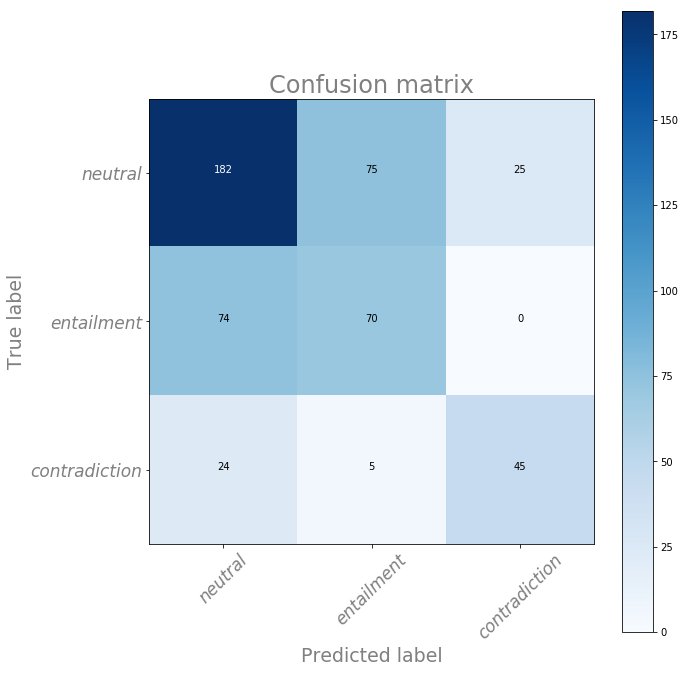

Accuracy:  0.5940


,Precision,Recall,Fscore
NEUTRAL,0.650000,0.645390,0.647687
ENTAILMENT,0.466667,0.486111,0.476190
CONTRADICTION,0.642857,0.608108,0.625000


CPU times: user 1.77 s, sys: 656 ms, total: 2.42 s
Wall time: 1.54 s


In [23]:
%%time

evaluate(rnn, dev_loader, writer=writer)

# Evaluate the model on test

In [ ]:
%%time

# evaluate(rnn, test_loader)